### Quelle einiger Code Snips und inspiration: https://towardsdatascience.com/analyzing-political-manifestos-through-natural-language-processing-and-dashboarding-4ad1d62d6b9a

In [1]:
import re

In [2]:
import yaml
import pandas as pd

DATA_DIR = "data"


def load_yaml_file(file_path):
    # reads the yml files as a dictionary, were each topic is a key and the values are a list of elements
    with open(file_path, "r", encoding='UTF-8') as stream:
        yaml_dict = yaml.safe_load(stream)
        return yaml_dict


def load_markdown_file(file_path):
    with open(file_path, "r", encoding='UTF-8') as stream:
        markdown_str = stream.read()
        return markdown_str


def get_counts(df: pd.DataFrame, label_col: str = "label") -> pd.DataFrame:
    """
    Get the labels count in a dataframe.
   
    """
    count_df = df[label_col].value_counts().to_frame().reset_index()
    count_df.columns = [label_col, "sentence_count"]
    count_df["percent"] = count_df.sentence_count / count_df.sentence_count.sum() * 100
    return count_df

In [13]:
!python -m spacy download de_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.8/567.8 MB 3.4 MB/s eta 0:00:0000:0100:02
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_lg')


In [3]:
from typing import Dict, List
import spacy
from string import punctuation
import pandas as pd
from tqdm.auto import tqdm
from transformers import pipeline


def _add_sentence_to_list(sentence: str, sentences_list):
    """
    Add a sentence to the list of sentences.
    Args:
        sentence (str):
            Sentence to be added.
        sentences (List[str]):
            List of sentences.
    """
    while sentence.startswith(" "):
        # remove leading space
        sentence = sentence[1:]
    if all(c in punctuation for c in sentence) or len(sentence) == 1:
        # skip sentences with only punctuation
        return
    sentences_list.append(sentence)


def get_sentences(text: str):
    """
    Get sentences from a text.
    Args:
        text (str):
            Text to be processed.
    Returns:
        List[str]:
            List of sentences.
    """
    # get the paragraphs
    text=   re.sub(" \d+\n", ".", text)
    text=   re.sub("\n\d+", " ", text)
    text=   re.sub("\n", " ", text)
    text=   re.sub("\d+.", "", text)
    paragraphs = re.split(r' *[\.\?!][\'"\)\]]* *', text)
    paragraphs = [p for p in paragraphs if p != ""]
    # get the sentences from the paragraphs
    sentences = list()
    for paragraph in paragraphs:
        if paragraph.startswith("#"):
            _add_sentence_to_list(paragraph, sentences)
            continue
        prev_sentence_idx = 0
        for idx in range(len(paragraph)):
            if idx + 1 < len(paragraph):
                if (paragraph[idx] == "." and not paragraph[idx + 1].isdigit()) or (
                    paragraph[idx] in "!?"
                ):
                    sentence = paragraph[prev_sentence_idx : idx + 1]
                    _add_sentence_to_list(sentence, sentences)
                    prev_sentence_idx = idx + 1
            else:
                sentence = paragraph[prev_sentence_idx:]
                _add_sentence_to_list(sentence, sentences)
    return sentences


def get_words(text: str) -> List[str]:
    """
    Get every word in the text that isn't a stopword or punctuation,
    and that is either a noun, adjective, verb or interjection
    """
    nlp = spacy.load("de_core_news_lg")
    nlp.max_length = 8000000
    doc = nlp(text)
    words = [
        word.text.replace("\n", "").replace("*", "")  # remove new line and bold symbols
        for word in doc
        if not word.is_stop  # remove stopwords
        and not word.is_punct  # remove punctuation
        and (
            word.pos_ == "NOUN"  # noun
            or word.pos_ == "ADJ"  # adjective
            or word.pos_ == "VERB"  # verb
            or word.pos_ == "INTJ"  # interjection
            or word.pos_ == "X"  # other
        )
    ]
    # remove blank words and spaces
    words = [word for word in words if word != ""]
    words = [word.replace(" ", "") for word in words]
    # make all words lowercase
    words = [word.lower() for word in words]
    # remove undesired words
    words = [
        word
        for word in words
        if word not in [ "Politik","Politiker"]
    ]
    # remove words with less than 3 characters
    words = [word for word in words if len(word) > 2]
    return words


def get_topical_sentences(
    sentences, topics, df_y=0
) :

    "classifies the content based on the frequency of the occurring words of the classes"
    sent_df=[]
    topical_sentences = dict()
    topics_list=[]
    for topic in topics:
        topics_list.append(topic)
        topical_sentences[topic] = list()
        #topical_sentences[f'{topic}_num'] = list()
    for sentence in sentences:
        topic_list=[]
        for topic in topics:
            if any(str(topical_word) in str(sentence.lower()) for topical_word in topics[topic]):
                for  topical_word in topics[topic]:
                        if str(topical_word) in str(sentence.lower()):
                            topic_num+=1
                
                
            else:
                topic_num=0
            topic_list.append(topic_num)
        
        topical_sentences[topics_list[max(range(len(topic_list)), key=topic_list.__getitem__)]].append(sentence)
        if df_y:
            sent_df.append([sentence,topics_list[max(range(len(topic_list)), key=topic_list.__getitem__)]])
    if df_y:
        return pd.DataFrame(data=sent_df,columns=['text','topic'])

    return topical_sentences




In [9]:
lsit=[1,2,3,8,2,5]
lsit[max(range(len(lsit)), key=lsit.__getitem__)]

8

In [4]:
from typing import Dict, List
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.graph_objects import Figure
import os
import pandas as pd



def get_word_cloud(
    words: List[str],
    max_words: int = 500,
    image_path: str = None,
    image_name: str = None,
):
    """
    Create a word cloud based on a set of words.
    """
    # change the value to black
    def black_color_func(
        word, font_size, position, orientation, random_state=None, **kwargs
    ):
        return "hsl(0,100%, 1%)"

    # set the wordcloud background color to white
    # set width and height to higher quality, 3000 x 2000
    wordcloud = WordCloud(
        font_path="/Library/Fonts/Arial Unicode.ttf",
        background_color="white",
        width=3000,
        height=2000,
        max_words=max_words,
    ).generate(" ".join(words))
    # set the word color to black
    wordcloud.recolor(color_func=black_color_func)
    # set the figsize
    plt.figure(figsize=[15, 10])
    # plot the wordcloud
    plt.imshow(wordcloud, interpolation="bilinear")
    # remove plot axes
    plt.axis("off")
    if image_path is not None and image_name is not None:
        # save the image
        plt.savefig(os.path.join(image_path, image_name), bbox_inches="tight")


def plot_topical_presence(
    sentences: List[str],
    topics: Dict[str, List[str]],
    title: str = None,
    color: str = "blue",
    height: int = 300,
) :
    """
    Plot the number of sentences per topic.
    """
    topical_sentences = get_topical_sentences(sentences, topics)
    topic_sentence_count = dict()
    for topic in topical_sentences.keys():
        topic_sentence_count[topic] = len(topical_sentences[topic])
    topic_sentence_count = pd.DataFrame(
        topic_sentence_count, index=["sentence_count"]
    ).T
    topic_sentence_count["sentence_percentage"] = (
        topic_sentence_count["sentence_count"] / len(sentences) * 100
    )
    topic_sentence_count.index.name = "topic"
    topic_sentence_count.sort_index(inplace=True)
    fig = px.bar(topic_sentence_count, x="sentence_percentage", orientation="h")
    fig.update_layout(
        title=title,
        xaxis_title="Prozent",
        yaxis_title="Topic",
        yaxis=dict(categoryorder="category descending"),
        margin=dict(l=0, r=0, b=0, t=0, pad=0),
        height=height,
    )
    fig.update_traces(marker_color=color)
    return fig


def plot_approaches(
    sentences: List[str],
    approaches: Dict[str, List[str]],
    title: str = None,
    height: int = 300,
):
    """
    Plot the approaches taken to language and policy.
    """
    approach_sentences = get_topical_sentences(sentences, approaches)
    approach_sentence_count = dict()
    total_num_sentences_in_approaches = sum(
        [len(approach_sentences[approach]) for approach in approach_sentences.keys()]
    )
    for approach in approaches:
        approach_sentence_count[approach] = (
            len(approach_sentences[approach]) / total_num_sentences_in_approaches * 100
        )
    fig = go.Figure()
    fig.add_trace(
        go.Bar(
            x=[approach_sentence_count["rational"]],
            name="rational",
            orientation="h",
            marker=dict(color="green"),
            hovertemplate="rational: %{x:.1f}%<extra></extra>",
        )
    )
    fig.add_trace(
        go.Bar(
            x=[approach_sentence_count["Intuitionen"]],
            name="intuition",
            orientation="h",
            marker=dict(color="red"),
            hovertemplate="intuition: %{x:.1f}%<extra></extra>",
        )
    )
    fig.update_layout(
        title=title,
        barmode="stack",
        xaxis=dict(
            showgrid=False,  # thin lines in the background
            zeroline=False,  # thick line at x=0
            visible=False,  # numbers below
        ),
        yaxis=dict(
            showgrid=False,  # thin lines in the background
            zeroline=False,  # thick line at x=0
            visible=False,  # numbers below
        ),
        margin=dict(l=0, r=0, b=0, t=0, pad=0),
        height=height,
    )
    return fig


def plot_sentiment(
    df: pd.DataFrame, title: str = None, height: int = 300, label_col: str = "label"
):
    """
    Plot the predicted sentiment of the sentences.
    """
    sentiments_count = get_counts(df, label_col=label_col)
    labels_order = ["neutral", "positiv", "negativ"]
    fig = px.bar(
        x=labels_order,
        y=[
            float(sentiments_count[sentiments_count[label_col] == label].percent)
            for label in labels_order
        ],
        title=title,
    )
    fig.update_traces(
        marker_color=["gray", "green", "red"],
        hovertemplate="%{y:.1f}%<extra></extra>",
    )
    fig.update_layout(
        xaxis_title="Sntiment",
        yaxis_title="Prozent",
        margin=dict(l=0, r=0, b=0, t=0, pad=0),
        height=height,
    )
    return fig


def plot_hate_speech(
    df: pd.DataFrame, title: str = None, height: int = 300, label_col: str = "label"
) :
    """
    Show the percentage of estimated hate speech sentences.
    """
    hate_count = get_counts(df, label_col=label_col)
    try:
        hate_percent = hate_count[hate_count[label_col] == "negativ"].percent.values[0]
    except IndexError:
        hate_percent = 0
    fig = go.Figure(
        go.Indicator(
            mode="number",
            value=hate_percent,
            title=title,
            number=dict(suffix="%", valueformat=".2f"),
            delta=dict(position="top", reference=320),
            domain=dict(x=[0, 1], y=[0, 1]),
        )
    )
    fig.update_layout(
        paper_bgcolor="darkred",
        font_color="white",
        margin=dict(l=0, r=0, b=0, t=0, pad=0),
        height=height,
    )
    return fig

In [5]:
import os
import sys
from ipywidgets import interact
import plotly.io as pio
from string import punctuation

In [12]:
pio.templates.default = "plotly_white"
data_name = None
party_data = None
party_names = None
selected_party = None

In [14]:
DATA_DIR='data/raw'

In [15]:
data_names = os.listdir(DATA_DIR)
data_names = [name[:-4] for name in data_names if name != ".DS_Store"]

In [16]:
data_names

['DIE_GRUENEN_Wahlprogramm_2021',
 'FDP_Wahlprogramm_2021',
 'DIE_LINKE_Wahlprogramm_2021',
 'CDU-CSU_Wahlrprogramm_2021',
 'SPD_Wahlprogramm_2021',
 'AFD_Wahlprogramm_2021']

In [17]:
@interact
def set_data(data=data_names):
    global data_name
    global party_data
    global party_names
    data_name = data
    party_data = load_yaml_file('topic_modeling/paties.yml')
    party_names = list(party_data.keys())

interactive(children=(Dropdown(description='data', options=('DIE_GRUENEN_Wahlprogramm_2021', 'FDP_Wahlprogramm…

In [18]:
def list_lemma(lsit):
    liste=[]
    string=' '.join(lsit)
    nlp = spacy.load("de_core_news_lg")
    doc = nlp(str(string))
    for token in tqdm(doc):
        if not token.is_stop and not token.is_punct:
            liste.append(token.lemma_.lower())
    return list(dict.fromkeys(liste)) 
topics = load_yaml_file('topic_modeling/topic_g.yml')

for topic in topics.keys():
    topics[topic]=list_lemma(topics[topic])


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

In [41]:
topics['wirtschaft'][0:5]


['Steuer', 'Steuerarten', 'Einkommensteuer', 'Finanzierung', 'Finanzen']

In [42]:
' '.join(topics['wirtschaft'][0:8])

'Steuer Steuerarten Einkommensteuer Finanzierung Finanzen Wirtschaft Volkswirtschaft Marktwirtschaft'

In [43]:
def list_lemma(lsit):
    liste=[]
    string=' '.join(lsit)
    nlp = spacy.load("de_core_news_lg")
    doc = nlp(str(string))
    for token in tqdm(doc):
        if not token.is_stop and not token.is_punct:
            liste.append(token.lemma_.lower())
    return list(dict.fromkeys(liste))  

In [53]:
for topic in topics.keys():
    topics[topic]=list_lemma(topics[topic])

  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

In [54]:
topics['wirtschaft'][0:10]

['steuer',
 'steuerart',
 'einkommensteuer',
 'finanzierung',
 'finanz',
 'wirtschaft',
 'volkswirtschaft',
 'marktwirtschaft',
 'planwirtschaft',
 'sozial']

In [55]:
approaches = load_yaml_file(os.path.join('topic_modeling', "approaches.yml"))
approaches.keys()

dict_keys(['rational', 'Intuitionen'])

In [56]:
data_name

'DIE_GRUENEN_Wahlprogramm_2021'

In [57]:
program_txt = load_markdown_file(os.path.join(DATA_DIR, f"{data_name}.txt"))


In [43]:
program_txt[:100]


'Deutschland. Aber normal. normal.\n\nProgramm der Alternative für Deutschland\nfür die Wahl zum 20. Deu'

In [58]:
sentences = get_sentences(program_txt)


In [39]:
sentences[0:10]

['Deutschland',
 'Aber normal',
 'normal',
 'Programm der Alternative für Deutschland für die Wahl zum 20',
 'Deutschen Bundestag  AD',
 'Inhaltsverzeichnis  Demokratie und Rechtsstaat',
 'Das Volk ist der Souverän',
 'Volksabstimmungen nach Schweizer Modell',
 'Die Gewaltenteilung gewährleisten',
 'Entpolitisierung der Justiz']

In [59]:
def text_lemma(lsit):
    liste=[]
    nlp = spacy.load("de_core_news_lg",disable=['parser', 'ner','tagger'])
    doc = nlp(lsit)
    for token in doc:
        if not token.is_stop and not token.is_punct:
            liste.append(token.lemma_.lower())

    return ' '.join(liste)

In [60]:
sent=[]
for text in tqdm(sentences):
    sent.append(text_lemma(text))

  0%|          | 0/4880 [00:00<?, ?it/s]

In [95]:
data_names = list(filter(None, data_names))

In [96]:
for element in list(filter(None, data_names)):
    program_txt = load_markdown_file(f"data/{element}.txt")
    sentences = get_sentences(program_txt)
    
    file = open(f'data/{element}_sentences.txt','w', encoding='UTF-8')
    for item in sentences:
        file.write(item+"§")
    file.close()

In [ ]:
def create_file(data_names):
    for element in list(filter(None, data_names)):
        program_txt = load_markdown_file(f"data/{element}.txt")
        sentences = get_sentences(program_txt)
        sent=[]
        for text in tqdm(sentences):
            sent.append(text_lemma(text))
        #file = open(,'w')
        with open(f'data/{element}_sent_lemma_list.txt', "w", encoding='UTF-8') as file:
        #write the list of data to the file
            file.writelines(sent)
create_file(data_names)   

In [42]:
list(filter(None, data_names))

['DIE_GRUENEN_Wahlprogramm_2021',
 'FDP_Wahlprogramm_2021',
 'DIE_LINKE_Wahlprogramm_2021',
 'CDU-CSU_Wahlrprogramm_2021',
 'SPD_Wahlprogramm_2021',
 'AFD_Wahlprogramm_2021']

In [ ]:
for element in list(filter(None, data_names)):
    print(element)
    program_txt = load_markdown_file(f"data/{element}.txt")
    sentences = get_sentences(program_txt)
    sent=[]
    for text in tqdm(sentences):
        sent.append(text_lemma(text))
    file = open(f'data/{element}_sent_lemma_list.txt','w',encoding='UTF-8')
    for item in sent:
        file.write(item+" § ")
    file.close()
    
    
    

    

In [ ]:
for text in tqdm(sentences):
        sent.append(text_lemma(text))

In [51]:
with open('data/DIE_GRUENEN_Wahlprogramm_2021_sent_lemma_list.txt', 'r') as f:
    content = f.read()
    sent = content.split(' § ')
    sent=sent[:-1]

In [54]:
words = get_words(' '.join(sent))

In [55]:
words[:10]


['bundestagswahlprogramm',
 'bundestagswahlprogramm',
 'bundesdelegiertenkonferenz',
 'bündnis',
 'grünen',
 'beschließen',
 'juni',
 'stattfinden',
 'herausgeberin',
 'bündnis']

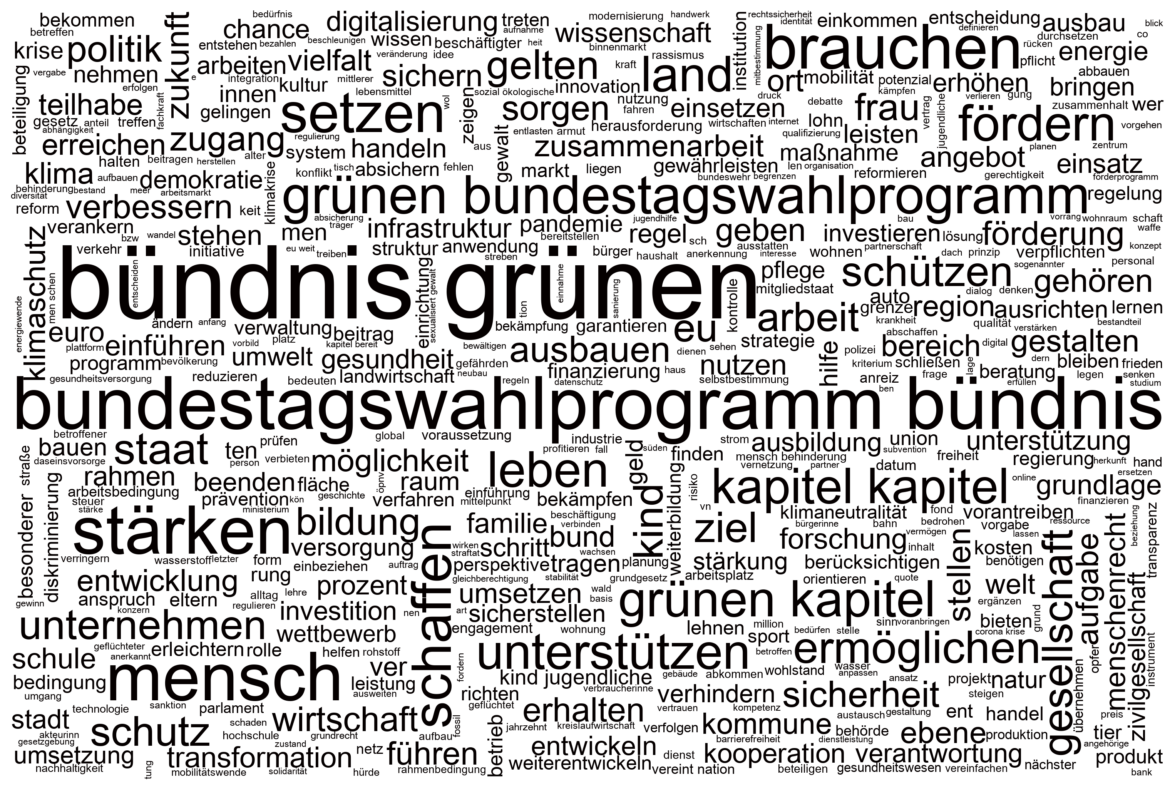

In [57]:
get_word_cloud(words)


In [62]:
topical_sentences = get_topical_sentences(sent, topics)


In [63]:
topic_sentence_count = dict()
for topic in topics:
    topic_sentence_count[topic] = len(topical_sentences[topic])

In [33]:
# sent
with open('data/DIE_GRUENEN_Wahlprogramm_2021_sent_lemma_list.txt', 'r', encoding='UTF-8') as f:
    content = f.read()
    sent = content.split(' § ')
    sent = sent[:-1]

In [64]:
topic_sentence_count


{'wirtschaft': 1160,
 'Klima': 370,
 'Bildung': 95,
 'Gesundheit': 147,
 'Wissenschaft': 135,
 'soziale Ursachen': 204,
 'Politik und Ideologie': 2120,
 'Infrastruktur': 649}

In [65]:
df_top=get_topical_sentences(sent, topics,1)

In [66]:
df_top.head()

,text,topic
0,ieittesaltentr,soziale Ursachen
1,bundestagswahlprogramm,Politik und Ideologie
2,bereit,wirtschaft
3,bundestagswahlprogramm bundesdelegiertenkonf...,Politik und Ideologie
4,herausgeberin bündnis grünen platz tor,Politik und Ideologie


In [133]:
# create csv 
def automated_topical_sentences(data_names, topics):
    for element in list(filter(None, data_names)):
        program_txt = load_markdown_file(f"data/raw/{element}.txt")
        sentences = get_sentences(program_txt)
        for text in tqdm(sentences):
            sent.append(text_lemma(text))
        df1 = get_topical_sentences(sent, topics,1)
        df1.to_csv(f'{element}.csv', index = True)

In [132]:
automated_topical_sentences(data_names, topics)


In [146]:
# read dataframes
df1 = pd.read_csv('preprocessing/AFD_Wahlprogramm_2021_sent_lemma_list.csv')
df2 = pd.read_csv('preprocessing/CDU-CSU_Wahlrprogramm_2021_sent_lemma_list.csv')
df3 = pd.read_csv('preprocessing/DIE_GRUENEN_Wahlprogramm_2021_sent_lemma_list.csv')
df4 = pd.read_csv('preprocessing/DIE_LINKE_Wahlprogramm_2021_sent_lemma_list.csv')
df5 = pd.read_csv('preprocessing/FDP_Wahlprogramm_2021_sent_lemma_list.csv')
df6 = pd.read_csv('preprocessing/SPD_Wahlprogramm_2021_sent_lemma_list.csv')

#display dataframes 
dataframes = [df1, df2, df3, df4, df5, df6]
for i in dataframes: 
    display(i)

,Unnamed: 0,text,topic
0,0,deutschland,wirtschaft
1,1,normal,wirtschaft
2,2,normal,wirtschaft
3,3,programm alternative deutschland wahl deutsc...,wirtschaft
4,4,inhaltsverzeichnis demokratie rechtsstaat,wirtschaft
...,...,...,...
1908,1908,bankverbindung alternative deutschland berline...,wirtschaft
1909,1909,afd-id www,wirtschaft
1910,1910,afd,wirtschaft
1911,1911,de spenden paypal@alternativefuer,wirtschaft


,Unnamed: 0,text,topic
0,0,inhaltsverzeichnis einleitung,wirtschaft
1,1,sssonnsnsssnnsnssnnnnnnsnnnnnnsnnnnnssnnnssnsn...,wirtschaft
2,2,verantwortung deutschland welt überzeugung fri...,wirtschaft
3,3,oossssssssssnnssssonnnnsssnnnnssnnnnsssnnnnsns...,wirtschaft
4,4,stärkung werte- regelbasiert international ord...,wirtschaft
...,...,...,...
2857,2857,international stark abstimmen kontrollieren wer-,wirtschaft
2858,2858,unterstützen bewerbung international sportlich...,wirtschaft
2859,2859,ökologisch ökonomisch sozial nachhaltig breit ...,wirtschaft
2860,2860,maßstab bewerbung olympisch spiel deutschland,wirtschaft


,Unnamed: 0,text,topic
0,0,ieittesaltentr,wirtschaft
1,1,bundestagswahlprogramm,wirtschaft
2,2,bereit,wirtschaft
3,3,bundestagswahlprogramm bundesdelegiertenkonf...,wirtschaft
4,4,herausgeberin bündnis grünen platz tor,wirtschaft
...,...,...,...
4875,4875,,wirtschaft
4876,4876,f,wirtschaft
4877,4877,zweistaatenregelung,wirtschaft
4878,4878,bundestagswahlprogramm,wirtschaft


,Unnamed: 0,text,topic
0,0,zeitzu handeln,wirtschaft
1,1,sozial sicherheit frieden klimagerechtigkeit ...,wirtschaft
2,2,linke,wirtschaft
3,3,wahlprogramm partei linke bundestagswahl,wirtschaft
4,4,beschlosse bundesparteitag juni,wirtschaft
...,...,...,...
5217,5217,jörg schindler bundesgeschäftsführer linke f...,wirtschaft
5218,5218,drucken recycling offset prozent altpapier,wirtschaft
5219,5219,ww\w,wirtschaft
5220,5220,die-linke,wirtschaft


,Unnamed: 0,text,topic
0,0,frei demokrat frei demokrat beschluss ord,wirtschaft
1,1,bundesparteitag frei demokrat mai,wirtschaft
2,2,bleiben,wirtschaft
3,3,cccccceeee see essen een ee e ee error eeeeeer...,wirtschaft
4,4,land stecken,wirtschaft
...,...,...,...
2263,2263,diskriminierende altersgrenz abschaffen frei...,wirtschaft
2264,2264,gesetz satzung beschrän- kend altersgrenz mögl...,wirtschaft
2265,2265,frei demokrat frei demokrat fdp fdp-bundesge...,wirtschaft
2266,2266,-- erfahren fdp,wirtschaft


,Unnamed: 0,text,topic
0,0,> | > ezdrespekt au |,wirtschaft
1,1,> zukunftsprogramm spd wofür stehen,wirtschaft
2,2,antreibt,wirtschaft
3,3,wonach streben,wirtschaft
4,4,sozial politik,wirtschaft
...,...,...,...
1708,1708,lebensstandard ausbeutung mensch natur beruhen,wirtschaft
1709,1709,weder deutschland europa region welt,wirtschaft
1710,1710,werben programm,wirtschaft
1711,1711,spd-parteivorstand seite >,wirtschaft


In [ ]:
#plotting for multiple 
def plot_topical_presence_df_CHANGED(
    dataframes,
    title: str = None,
    color: str = "blue",
    height: int = 300,
) :
    """
    Plot the number of sentences per topic.
    """
    for df in dataframes: 
        topic_sentence_count = dict()
        for topic in df['topic'].unique().tolist():
            topic_sentence_count[topic] = len(len(df['topic'==topic].index))
        topic_sentence_count = pd.DataFrame(
            topic_sentence_count, index=["sentence_count"]
        ).T
        topic_sentence_count["sentence_percentage"] = (
            topic_sentence_count["sentence_count"] / len(sentences) * 100
        )
        topic_sentence_count.index.name = "topic"
        topic_sentence_count.sort_index(inplace=True)
        fig = px.bar(topic_sentence_count, x="sentence_percentage", orientation="h")
        fig.update_layout(
            title=title,
            xaxis_title="Prozent",
            yaxis_title="Topic",
            yaxis=dict(categoryorder="category descending"),
            margin=dict(l=0, r=0, b=0, t=0, pad=0),
            height=height,
        )
        fig.update_traces(marker_color=color)
        fig.write_image(f"images/{df}_topical_presence.png")
        return fig

plot_topical_presence_df_CHANGED(dataframes)

In [155]:
def plot_topical_presence_df(
    df,
    file,
    title: str = None,
    color: str = "blue",
    height: int = 300,
) :
    """
    Plot the number of sentences per topic.
    """
    
    topic_sentence_count = dict()
    for topic in df['topic'].unique().tolist():
        topic_sentence_count[topic] = len(len(df['topic'==topic].index))
    topic_sentence_count = pd.DataFrame(
        topic_sentence_count, index=["sentence_count"]
    ).T
    topic_sentence_count["sentence_percentage"] = (
        topic_sentence_count["sentence_count"] / len(sentences) * 100
    )
    topic_sentence_count.index.name = "topic"
    topic_sentence_count.sort_index(inplace=True)
    fig = px.bar(topic_sentence_count, x="sentence_percentage", orientation="h")
    fig.update_layout(
        title=title,
        xaxis_title="Prozent",
        yaxis_title="Topic",
        yaxis=dict(categoryorder="category descending"),
        margin=dict(l=0, r=0, b=0, t=0, pad=0),
        height=height,
    )
    fig.update_traces(marker_color=color)
    fig.write_image(f"images/{file}_topical_presence.png")
    return fig


In [75]:
program_txt = load_markdown_file(f"data/raw/DIE_GRUENEN_Wahlprogramm_2021.txt")
sentences = get_sentences(program_txt)

In [77]:
df_top['test']=sentences

In [78]:
df_top.head()

,text,topic,test
0,ieittesaltentr,soziale Ursachen,IEITTESALTENTR Alles ist drin
1,bundestagswahlprogramm,Politik und Ideologie,Bundestagswahlprogramm
2,bereit,wirtschaft,"Bereit, weil Ihr es seid"
3,bundestagswahlprogramm bundesdelegiertenkonf...,Politik und Ideologie,Dieses Bundestagswahlprogramm wurde auf der B...
4,herausgeberin bündnis grünen platz tor,Politik und Ideologie,Herausgeberin: BÜNDNIS DIE GRÜNEN Platz vor d...


In [79]:
plot_topical_presence(
    sentences, 
    topics, 
    title=f"Topic Verteilung  {selected_party.upper()}",
    color=party_data[selected_party]["color"],
)

In [80]:
plot_approaches(sentences, approaches)

In [82]:
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer

sentiment_model_path = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer=AutoTokenizer.from_pretrained(sentiment_model_path,use_fast=False)
sentiment_task = pipeline(
    "sentiment-analysis", model=sentiment_model_path, tokenizer=tokenizer
)
sentiment_task("ich finde es gut")

[{'label': 'positive', 'score': 0.8837923407554626}]

In [12]:
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer
def get_sentiment(sentences):
    "based on pretrained model try to identify which elements have which sentiment"
    sentiment_model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
    tokenizer=AutoTokenizer.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment",use_fast=False)
    sentiment_task = pipeline(
        "sentiment-analysis", model=sentiment_model_path, tokenizer=tokenizer
    )
    sentiment_outputs = [
        sentiment_task(sentence)
        for sentence in tqdm(sentences, desc="Sentiment analysis")
    ]
    sentiments_dict = dict(label=[], score=[], sentence=[])
    for idx, output in enumerate(sentiment_outputs):
        sentiments_dict["label"].append(output[0]["label"])
        sentiments_dict["score"].append(output[0]["score"])
        sentiments_dict["sentence"].append(sentences[idx])
    sentiment_df = pd.DataFrame(sentiments_dict)
    sentiment_df["label"] = sentiment_df.label.map(
        dict(positive="positiv", negative="negativ", neutral="neutral")
    )
    return sentiment_df



In [84]:
sentiment_df = get_sentiment(sentences)


Sentiment analysis:   0%|          | 0/4880 [00:00<?, ?it/s]

In [ ]:
sentiment_df.head()

,label,score,sentence
0,neutral,0.889235,IEITTESALTENTR Alles ist drin
1,neutral,0.684151,Bundestagswahlprogramm
2,positiv,0.540158,"Bereit, weil Ihr es seid"
3,neutral,0.824043,Dieses Bundestagswahlprogramm wurde auf der B...
4,neutral,0.853210,Herausgeberin: BÜNDNIS DIE GRÜNEN Platz vor d...


In [ ]:
sentiment_df.label.value_counts()

neutral    3904
negativ     645
positiv     331
Name: label, dtype: int64

In [ ]:
#sentiment_df[sentiment_df.label == "negativ"].sentence.sample(10).values


array(['Düngemittel, Pestizide, Waschmittelrückstände und Medikamentenreste gehören nicht in unser Wasser',
       'BÜNDNIS DIE GRÜNEN    Kapitel',
       'Abkommen mit negativen Auswirkungen auf die Umwelt oder die Ernährungssouveränität wie das EU-Mercosur-Abkommen mit latein- amerikanischen Staaten lehnen wir ab',
       'BÜNDNIS DIE GRÜNEN    Kapitel',
       'Plastikmüll soll nicht mehr exportiert wer- den, wenn er nicht hochwertig recycelt wird',
       'Die Klimakrise und die Endlichkeit von Ressourcen verlangen ein Umsteuern',
       'Großstädte teilen sich immer stärker in Ein- kommensstadtteile auf, Innenstädten geht das Leben verloren',
       'Wird dieses Leid nicht aufgearbei- tet, beeinträchtigt es das Leben dieser Menschen und ihrer Familien sowie den gesellschaftlichen Zusammenhalt über Generationen',
       'BÜNDNIS DIE GRÜNEN    Kapitel',
       'Und ohne Satelli- tenbilder ließe sich etwa die Vertreibung ganzer Dorfgemeinschaften in Kriegsgebieten gar nicht erst nach

In [ ]:
#sentiment_df[sentiment_df.label == "positiv"].sentence.sample(10).values


array(['Ein Patenschafts- programm nach dem Vorbild Kanadas kann die Willkommenskultur fördern',
       'Die Polizist*innen verdienen unsere Wertschätzung, genauso wie gute Arbeitsverhältnisse und leistungsfähige Strukturen innerhalb der Behörden',
       'einen neuen Fokus setzen und unser Engagement deutlich steigern',
       'Jüdische Menschen in Deutschland müssen sich sicher fühlen können',
       'Wich- tig ist zudem, dass Deutschland und Europa schnell den Anschluss bei der Batteriezellenproduktion finden',
       'Bereit, weil Ihr es seid', 'Bereit, weil Ihr es seid',
       'Bereit, weil Ihr es seid', 'Bereit, weil Ihr es seid',
       'Bereit, weil Ihr es seid'], dtype=object)

In [13]:

def get_hate_speech(
    sentences, sentiment_df, label_col: str = "label"
):
    "Get the hate speech of a list of sentences."
    
    hate_model_path = "Hate-speech-CNERG/dehatebert-mono-german"
    hate_task = pipeline(
        "text-classification", model=hate_model_path, tokenizer=hate_model_path
    )
    hate_outputs = [
        hate_task(sentence) for sentence in tqdm(sentences, desc="Hate speech analysis")
    ]
    hate_dict = dict(label=[], score=[], sentence=[])
    for idx, output in enumerate(hate_outputs):
        hate_dict["label"].append(output[0]["label"])
        hate_dict["score"].append(output[0]["score"])
        hate_dict["sentence"].append(sentences[idx])
    hate_df = pd.DataFrame(hate_dict)
    hate_df["label"] = hate_df.label.map(dict(HATE="negativ", NON_HATE="neutral"))
    hate_condition = (hate_df.label == "negativ") & (sentiment_df[label_col] == "negativ")
    hate_df.loc[hate_condition, "label"] = "negativ"
    hate_df.loc[~hate_condition, "label"] = "neutral"
    return hate_df

In [ ]:
plot_sentiment(sentiment_df)


In [ ]:
hate_df=get_hate_speech(sentences,sentiment_df,label_col= "label")

Downloading:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/669M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/152 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Hate speech analysis:   0%|          | 0/4880 [00:00<?, ?it/s]

In [ ]:
hate_count = get_counts(hate_df, label_col='label')
hate_count

,label,sentence_count,percent
0,neutral,4876,99.918033
1,negativ,4,0.081967


In [ ]:
plot_hate_speech(hate_df)

In [ ]:

def get_topical_sentences_pip(
    sentences, topics
) :
    """
    Get lists of sentences per topic, based on the presence of
    words that are a part of the topic.
    Args:
        sentences (List[str]):
            List of sentences to analyse.
        topics (Dict[str, List[str]]):
            Dictionary of words per topic.
    Returns:
        Dict[str, List[str]]:
            Dictionary of sentences per topic.
    """
    topical_sentences = dict()
    topic_list=[x.lower() for x in list(topics.keys())+['None']]
    for topic in topic_list:
        topical_sentences[topic] = list()
    classifier = pipeline("zero-shot-classification",
                      model="valhalla/distilbart-mnli-12-1")
    for sentence in tqdm(sentences):
        class_sent=classifier(sentence, topic_list)
        topical_sentences[class_sent['labels'][max(range(len(class_sent['scores'])), key=class_sent['scores'].__getitem__)]].append(sentence)
    return topical_sentences

In [ ]:
get_topical_sentences_pip(sentences, topics)